<a href="https://colab.research.google.com/github/alfhi24/FinalProjectDTI/blob/add-license-1/Project_DTI_Machine_Learning_Method_MLP_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Library**


In [1]:
! pip3 install Sastrawi

     |████████████████████████████████| 215kB 7.6MB/s 


In [2]:
# Library for dataset
import pandas as pd
import numpy as np

# Library for data visualization
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

# Library for preprocessing
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Library for classification
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

#Library for Evaluation
from sklearn import metrics
import time
from mlxtend.plotting import plot_confusion_matrix

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### **Dataset**


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/asthala/racism-detection/master/datasetfix.csv')
df.head()

,tweets,label
0,Trus nih buat yg nanya kenapa gak dibangun di ...,Non_R
1,PLAY & Let The Fun Begin 😱\nLike + RT + Click ...,Non_R
2,Papua adalah bagian dari NKRI\n#DukungOtsusPap...,Non_R
3,Akar konflik harus dibicarakan.\nDan dicari ti...,Non_R
4,"""Saya minta kita semua jadi orang Papua. Artin...",Non_R


In [5]:
count_label =df.label.value_counts().to_frame()
px.bar(data_frame=count_label, x=count_label.index , y='label')

Dari barchart diatas, dataset yang digunakan memiliki imbalance data label, sehingga pada tahap preprocessing akan dilakukan SMOTE untuk menanggulangi data yang tidak seimbang

### **Preprocessing**

#### Data Cleaning

In [6]:
def clean(data):
  tweets = []
  for tweet in data:
      tweet = re.sub(r"'(?:\@|https?\://)\S+", "", tweet)
      tweet = re.sub('\n', '', tweet)
      tweet = re.sub('rt', '', tweet)
      tweet = re.sub("[^a-zA-Z^']", " ", tweet)
      tweet = re.sub(" {2,}", " ", tweet)
      tweet = tweet.strip()
      tweets.append(tweet)
  return tweets

In [7]:
df_clean = df.copy()
df_clean['tweets']= clean(df['tweets'])
df_clean.head()

,tweets,label
0,Trus nih buat yg nanya kenapa gak dibangun di ...,Non_R
1,PLAY Let The Fun Begin Like RT Click https www...,Non_R
2,Papua adalah bagian dari NKRI DukungOtsusPapua...,Non_R
3,Akar konflik harus dibicarakan Dan dicari titi...,Non_R
4,Saya minta kita semua jadi orang Papua Ainya k...,Non_R


#### Case Folding


In [8]:
def case_fold(data):
    return data.str.lower()

In [9]:
df_clean['tweets'] = case_fold(df_clean['tweets'])
df_clean.head()

,tweets,label
0,trus nih buat yg nanya kenapa gak dibangun di ...,Non_R
1,play let the fun begin like rt click https www...,Non_R
2,papua adalah bagian dari nkri dukungotsuspapua...,Non_R
3,akar konflik harus dibicarakan dan dicari titi...,Non_R
4,saya minta kita semua jadi orang papua ainya k...,Non_R


#### Tokenization


In [10]:
def token(data):
  return data.apply(nltk.word_tokenize)

In [11]:
df_clean['tweets'] = token(df_clean['tweets'])
df_clean.head()

,tweets,label
0,"[trus, nih, buat, yg, nanya, kenapa, gak, diba...",Non_R
1,"[play, let, the, fun, begin, like, rt, click, ...",Non_R
2,"[papua, adalah, bagian, dari, nkri, dukungotsu...",Non_R
3,"[akar, konflik, harus, dibicarakan, dan, dicar...",Non_R
4,"[saya, minta, kita, semua, jadi, orang, papua,...",Non_R


#### Stopword


In [12]:
def stop_words(data) :
  stop_words = set(stopwords.words('indonesian'))
  return data.apply(lambda x: [item for item in x if item not in stop_words])

In [13]:
df_clean['tweets'] = stop_words(df_clean['tweets'])
df_clean.head()

,tweets,label
0,"[trus, nih, yg, nanya, gak, dibangun, papua, a...",Non_R
1,"[play, let, the, fun, begin, like, rt, click, ...",Non_R
2,"[papua, nkri, dukungotsuspapuamaju]",Non_R
3,"[akar, konflik, dibicarakan, dicari, titik, te...",Non_R
4,"[orang, papua, ainya, kulit, hitam, kulit, put...",Non_R


#### Stemming


In [14]:
def stem(data):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return data.apply(lambda x: [ stemmer.stem(item) for item in x])

In [15]:
df_clean['tweets'] = stem(df_clean['tweets'])
df_clean.head()

,tweets,label
0,"[trus, nih, yg, nanya, gak, bangun, papua, aja...",Non_R
1,"[play, let, the, fun, begin, like, rt, click, ...",Non_R
2,"[papua, nkri, dukungotsuspapuamaju]",Non_R
3,"[akar, konflik, bicara, cari, titik, temu, sel...",Non_R
4,"[orang, papua, ainya, kulit, hitam, kulit, put...",Non_R


#### Racism Tweet Word Cloud

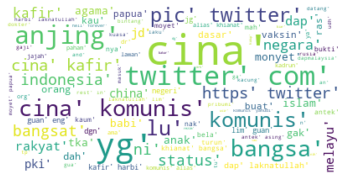

In [16]:
# Create and generate a word cloud image:
word = df_clean.tweets[df_clean['label']=='R'].astype('string')
word.head()
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_text(' '.join(word))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### TF-IDF


In [17]:
def tf_idf(data):
  vectorizer = TfidfVectorizer()
  return vectorizer, vectorizer.fit_transform(data)


In [18]:
df_clean['tweets'] = df_clean['tweets'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
df_clean.head()

,tweets,label
0,trus nih yg nanya gak bangun papua aja provins...,Non_R
1,play let the fun begin like rt click https www...,Non_R
2,papua nkri dukungotsuspapuamaju,Non_R
3,akar konflik bicara cari titik temu selesai sy...,Non_R
4,orang papua ainya kulit hitam kulit putih ramb...,Non_R


In [19]:
df_clean['tweets'][0]

'trus nih yg nanya gak bangun papua aja provinsi timur indonesia milik infrastruktur fasilitas olah lanjut pada freepo'

In [20]:
vec,x = tf_idf(df_clean['tweets'])
label = np.array(df_clean['label'].values)

#### SMOTE

In [21]:
sampler = SMOTE()
x_so, label_so = sampler.fit_resample(x,label)

In [22]:
Label_so = pd.DataFrame(data=label_so, columns=['label'])

In [23]:
count_label = Label_so['label'].value_counts().to_frame()
px.bar(data_frame=count_label, x=count_label.index , y='label')

####Split Train-Test

In [24]:
X_train_so, X_test_so, y_train_so, y_test_so = train_test_split(x_so, label_so, test_size=0.25, random_state=1)
print(X_train_so.shape)
print(X_test_so.shape)
print(y_train_so.shape)
print(y_test_so.shape)

(766, 3950)
(256, 3950)
(766,)
(256,)


In [25]:
y_test_so[0]

'Non_R'

In [26]:
lb_make = LabelEncoder()
y_train_so = lb_make.fit_transform(y_train_so)
print(y_train_so.shape)

(766,)


In [27]:
y_test_so = lb_make.fit_transform(y_test_so)
print(y_test_so.shape)

(256,)


In [28]:
y_test_so[0]

0

### **Classification**


##### **Train**

In [29]:
parameter_space = {
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
scoring = {'AUC': 'roc_auc', 
         'Accuracy': 'accuracy', 
         'Precision': 'precision_weighted', 
         'Recall':'recall_weighted', 
         'F1-Score':'f1_weighted'}


In [30]:
k = StratifiedKFold(n_splits=10, shuffle=False)
clf = GridSearchCV(MLPClassifier(max_iter=100), parameter_space, scoring=scoring, n_jobs=-1, cv=k,refit='AUC')
start = time.time()
clf.fit(X_train_so.toarray(), y_train_so)
stop = time.time()
print('Waktu Train ANN Over-sampling: {:.2f} s'.format(stop - start))

Waktu Train ANN Over-sampling: 1101.80 s


In [40]:
print("Accuracy Score Train:",clf.cv_results_['mean_test_Accuracy'][clf.best_index_])
print("Precision Score Train:",clf.cv_results_['mean_test_Precision'][clf.best_index_])
print("Recall Score Train:",clf.cv_results_['mean_test_Recall'][clf.best_index_])
print("F1-Score Train:",clf.cv_results_['mean_test_F1-Score'][clf.best_index_])
print("AUC Score Train:",clf.cv_results_['mean_test_AUC'][clf.best_index_])

Accuracy Score Train: 0.9189678742310321
Precision Score Train: 0.9207741854668232
Recall Score Train: 0.9189678742310321
F1-Score Train: 0.918846265971647
AUC Score Train: 0.9772498046736274


In [34]:
# Best paramete set
print('Best parameters found:\n', clf.best_estimator_)

Best parameters found:
 MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


##### **Test**

In [35]:
y_pred_soann = clf.predict(X_test_so.toarray())
# y_pred_soann

##### **Evaluation**

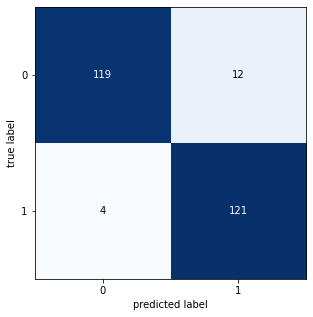

In [36]:
#Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test_so, y_pred_soann)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [37]:
print(metrics.classification_report(y_test_so, y_pred_soann))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       131
           1       0.91      0.97      0.94       125

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



In [61]:
print("Accuracy Score Test:", metrics.accuracy_score(y_test_so, y_pred_soann))
print("Precision Score Test:", metrics.precision_score(y_test_so, y_pred_soann))
print("Recall Score Test:", metrics.recall_score(y_test_so, y_pred_soann))
print("F1-Score Test:", metrics.f1_score(y_test_so, y_pred_soann))

Accuracy Score Test: 0.9375
Precision Score Test: 0.9097744360902256
Recall Score Test: 0.968
F1-Score Test: 0.937984496124031


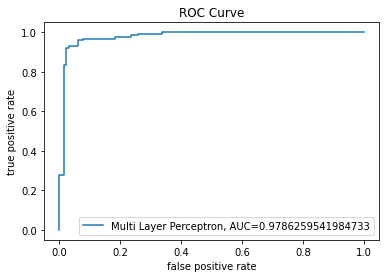

In [62]:
y_pred_soann_proba = clf.predict_proba(X_test_so.toarray())[::,1]
fprsoann, tprsoann, _ = metrics.roc_curve(y_test_so, y_pred_soann_proba)
aucsoann = metrics.roc_auc_score(y_test_so, y_pred_soann_proba)

# ROC Curves
plt.plot(fprsoann,tprsoann,label="Multi Layer Perceptron, AUC="+str(aucsoann))
plt.title('ROC Curve')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

##### **User Test**

In [60]:
sentence = "haloo" #@param
sentence = [sentence]
sentence = pd.DataFrame(data=sentence,columns=['text'], index=[0])
sentence['text'] = clean(sentence['text'])
sentence['text'] = case_fold(sentence['text'])
sentence['text'] = token(sentence['text'])
sentence['text'] = stop_words(sentence['text'])
sentence['text'] = stem(sentence['text'])
sentence['text'] = sentence['text'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
clean_sentence = vec.transform(sentence['text'])
y_pred = clf.predict(clean_sentence.toarray())
y_pred_proba = clf.predict_proba(clean_sentence.toarray())
label_pred = 'Racist' if np.round(y_pred[0]) else 'Not Racist'
print('Predicted =',label_pred)
print('Probability Predicted As "Racist" = ',y_pred_proba[0][1])
print('Probability Predicted As "Not Racist" = ',y_pred_proba[0][0])

Predicted = Not Racist
Probability Predicted As "Racist" =  0.17765630693941672
Probability Predicted As "Not Racist" =  0.8223436930605833
